In [63]:
import sys
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xray
import random
import itertools
import importlib as imp

sys.path.append('/nuwa_cluster/home/jackyu/climatools/')
import climatools.dates as climadates
import climatools.viz as climaviz
import climatools.misc as climamisc
import climatools.muths as climaths
import climatools.units as climaunits

#from IPython.lib.deepreload import reload as dreload
imp.reload(climadates)
imp.reload(climaviz)
imp.reload(climamisc)
imp.reload(climaths)
imp.reload(climaunits)

matplotlib.rcParams.update({'font.size': 13, 
                            'xtick.direction': 'out',
                            'ytick.direction': 'out'})

# TWPICE

# Cases and netCDF file paths

In [64]:
cases = {'LWclirad': '../examples/twpice_LWclirad_SWrrtmg/TWP_ICE_hres_intel_3hr_cam5_control/camrun.cam.h0.2006-01-17-10800.nc',
        'LWclirad no scat.': '../examples/twpice_LWclirad_SWrrtmg/TWP_ICE_hres_intel_3hr_cam5_control_NoCloudScattering/camrun.cam.h0.2006-01-17-10800.nc',
        'LWrrtmg': '../examples/twpice_LWrrtmg_SWrrtmg/TWP_ICE_hres_intel_3hr_cam5_control/camrun.cam.h0.2006-01-17-10800.nc'}

# Coordinate conversions
*lev* is converted from hybrid levels to mbar.    
*time* is converted from days since start to datetime.datetime objects

In [65]:
with xray.open_dataset(cases[random.choice(list(cases.keys()))], 
                       decode_times = False) as ds:
    pressure = climaunits.lev_hybrid2mbar(ds)
    datetimes = climadates.time2datetimes(ds)            

# Variables of dimensions (time, lev, lon, lat)

#### Open and copy in the interested variables from all cases
For all cases:

1. Set lev to mbar 
2. Set time to datetimes
3. Convert QRL to degree per day
4. Convert kg/kg to g/kg

In [67]:
def get_d3interests():
    d3interests = ['CLOUD', 'QRL', 'Q', 
                   'CLDICE', 'CLDLIQ', 
                   'AQSNOW', 'AREI', 'AREL']
    return d3interests

In [68]:
def prep_data():

    interests = get_d3interests()
    
    datasets = {} 

    for case, filepath in cases.items():
        with xray.open_dataset(filepath, decode_times = False) as ds:
            datasets[case] = ds[interests].copy(deep = True)
            datasets[case].attrs['case_name'] = case

    for name, ds in datasets.items():
        ds.coords['lev'] = ('lev', pressure, {'units': 'mbar'})
        ds.coords['time'] = ('time', datetimes, {'units': 'datetime'})
    
        if 'QRL' in ds:
            ds['QRL'] *= 86400
            ds['QRL'].attrs['units'] = 'K/day'
        
        for k in ['Q', ]:
            if k in ds:
                ds[k] *= 1e3
                ds[k].attrs['units'] = 'g/kg'
        
        for k in ['CLDICE', 'CLDLIQ', 'AQSNOW']:
            if k in ds:
                ds[k] *= 1e6
                ds[k].attrs['units'] = 'mg/kg'

    return datasets

d3sets = prep_data()

#### Compute difference between all cases for all interested variables

In [69]:
def prep_differences(datasets):
    diff_strs = [('LWclirad', 'LWrrtmg'), 
                 ('LWclirad no scat.', 'LWrrtmg'), 
                 ('LWclirad', 'LWclirad no scat.')]

    return {x + ' - ' + y: datasets[x] - datasets[y] 
            for x, y in diff_strs}    
    
diff_d3sets = prep_differences(d3sets)

#### Change/correct some of the attributes
Some of this is needed for labelling plots easily

In [70]:
def prep_attributes(datasets, diff_datasets):

    interests = get_d3interests()
    
    for ds_name, ds in diff_datasets.items():
        ds.attrs['case_name'] = ds_name
        for interest in interests:
            ds[interest].attrs = dict(datasets['LWrrtmg'][interest].attrs)
            ds[interest].attrs['case_name'] = ds_name
        
    for ds_name, ds in datasets.items():
        for interest in interests:
            ds[interest].attrs['case_name'] = ds_name
            
    return datasets, diff_datasets

d3sets, diff_d3sets = prep_attributes(d3sets, diff_d3sets)

#### Plotting functions

In [71]:
def contourf_interest_for_all_cases(dict_ds, interest = 'CLOUD',
                               contour_levels = None,
                                   cmap = matplotlib.cm.jet,
                                   extend = 'neither'):
    
    fig, axes = plt.subplots(nrows = 1, 
                             ncols = len(list(dict_ds.keys())),
                            figsize = (17, 5), dpi = 300)
    
    for axis, da in zip(axes, [dict_ds[case][interest] 
                               for case in sorted(dict_ds.keys())]):
        axis = climaviz.contourf_DataArray(axis, da, 
                                           contour_levels = contour_levels,
                                           cmap = cmap,
                                           extend = extend)
    plt.tight_layout()
        

# Variables of dimensions (lon, lat, time)

In [72]:
def get_d2interests():
    interests = ['FLNT', 'FLNS', 'CLDLOW', 'CLDMED', 'CLDHGH', 'CLDTOT']
    return interests

In [73]:
def prep_data():

    interests = get_d2interests()

    datasets = {}
    
    for casename, casepath in cases.items():
        with xray.open_dataset(casepath, decode_times = False) as ds:
            datasets[casename] = ds[interests].copy(deep = True)
            datasets[casename].attrs['case_name'] = casename
        
    for casename, ds in datasets.items():
        ds.coords['time'] = ('time', datetimes, {'units': 'datetime',
                                                'long_name': 'time'})
    return datasets

d2sets = prep_data()

#### Compute difference between all cases for all interested variables

In [74]:
def prep_differences(datasets):
    diff_strs = [('LWclirad', 'LWrrtmg'), 
                 ('LWclirad no scat.', 'LWrrtmg'), 
                 ('LWclirad', 'LWclirad no scat.')]

    return {x + ' - ' + y: datasets[x] - datasets[y] 
            for x, y in diff_strs}    

diff_d2sets = prep_differences(d2sets)

#### Change/correct some of the attributes
Some of this is needed for labelling plots easily

In [75]:
def prep_attributes(datasets, diff_datasets):
    
    interests = get_d2interests()
    
    for ds_name, ds in diff_datasets.items():
        ds.attrs['case_name'] = ds_name
        for interest in interests:
            ds[interest].attrs = dict(datasets['LWrrtmg'][interest].attrs)
            ds[interest].attrs['case_name'] = ds_name
        
    for ds_name, ds in datasets.items():
        for interest in interests:
            ds[interest].attrs['case_name'] = ds_name
            
    return datasets, diff_datasets

d2sets, diff_d2sets = prep_attributes(d2sets, diff_d2sets)

#### plotting functions

In [76]:
def get_line_props():
    return {'LWrrtmg': {'colour': 'g', 'linestyle': '--'},
           'LWclirad': {'colour': 'b', 'linestyle': '-'},
           'LWclirad no scat.': {'colour': 'b', 'linestyle': '--'}}

In [77]:
def plotVS_interest_for_all_cases(dsets, diff_dsets, interest = 'FLNT',
                                 left_ylim = (-1, 1),
                                 right_ylim = (-1, 1)):

    line_props = get_line_props()
    
    vspairs = [[p.strip() for p in diff_case.split('-')]
               for diff_case in sorted(diff_dsets.keys())]
    
    fig, axes = plt.subplots(figsize = (11, 11), dpi = 300,
                          nrows = len(vspairs), ncols = 1)
    
    handles, labels = [], []
    
    for ax, vspair in zip(axes, vspairs):
        x, y = vspair
        
        for model in vspair:
            ax = climaviz.plot_DataArray(ax, dsets[model][interest], 
                                         label = '{}'.format(model), 
                                         colour = line_props[model]['colour'],
                                         linestyle = line_props[model]['linestyle'],
                                         ylabel = interest, ylim = left_ylim)
        
        da = diff_dsets[' - '.join(vspair)][interest]        
        
        diff_colour = (0.929, 0.329, 0.972)
        ax2 = ax.twinx()
        ax2 = climaviz.plot_DataArray(ax2, da, label = 'difference',
                                      title = '',                              
                                      colour = diff_colour, linestyle = '-',
                                      ylim = right_ylim)
        ax2.set_ylabel('')
        [label.set_color(diff_colour) 
         for label in ax2.yaxis.get_ticklabels()]
        
        ### background shading for daytime and nighttime
        ax2 = climaviz.daytime_nighttime_shading(ax2, da.coords['time'].to_pandas().index,
                                       hour_daystart = 6, hour_nightstart = 18)
        
        ## collect handles and labels for legend later
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()    
        handles.extend(handles1 + handles2)
        labels.extend(labels1 + labels2)
   
    ## Make 1 legend for whole figure
    uhandles, ulabels = climamisc.any_unique_labels(handles, labels)
    uhandles, ulabels = zip(*sorted(zip(uhandles, ulabels), 
                                    key = lambda x: x[1]))
    fig.legend(uhandles, ulabels, 
               loc = 'upper center', ncol = 4,
               bbox_to_anchor = (.45, .9), prop = {'size': 12})
    
    fig.suptitle(da.attrs['long_name'])


# Plots

### Cloud fraction (CLOUD)

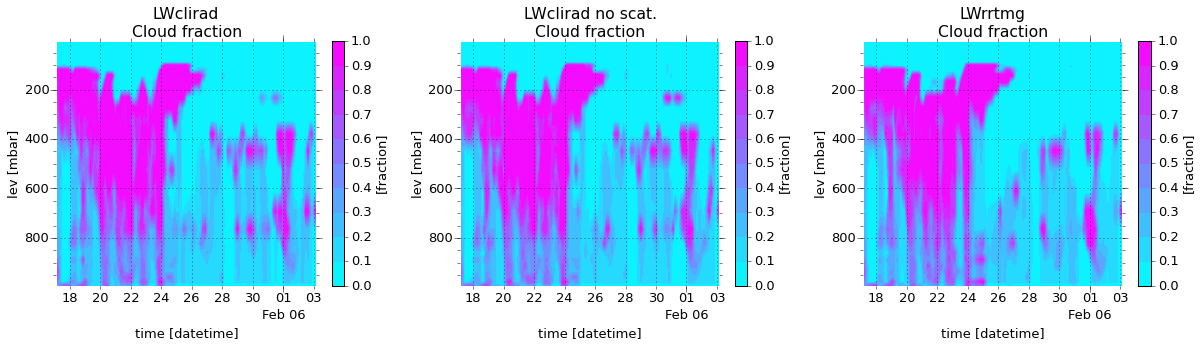

In [78]:
contourf_interest_for_all_cases(d3sets, interest = 'CLOUD', 
                                contour_levels = (0, 1, .1),
                               cmap = matplotlib.cm.cool)

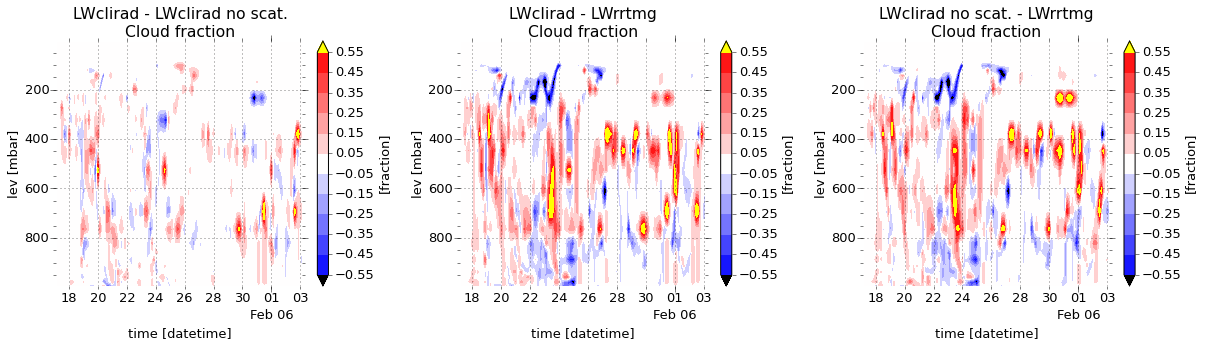

In [79]:
contourf_interest_for_all_cases(diff_d3sets, interest = 'CLOUD',
                               cmap = matplotlib.cm.bwr,
                               contour_levels = climaviz.symmetric_about_white_cmap_levels(.6, 11),
                               extend = 'both')

### Longwave heating rate (QRL)

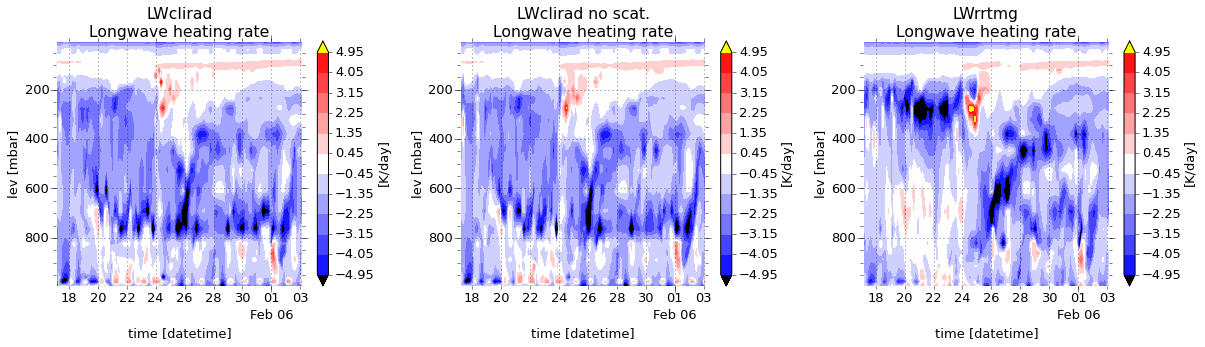

In [80]:
contourf_interest_for_all_cases(d3sets, interest = 'QRL',
                               contour_levels = climaviz.symmetric_about_white_cmap_levels(5, 11),
                                cmap = matplotlib.cm.bwr,
                               extend = 'both')

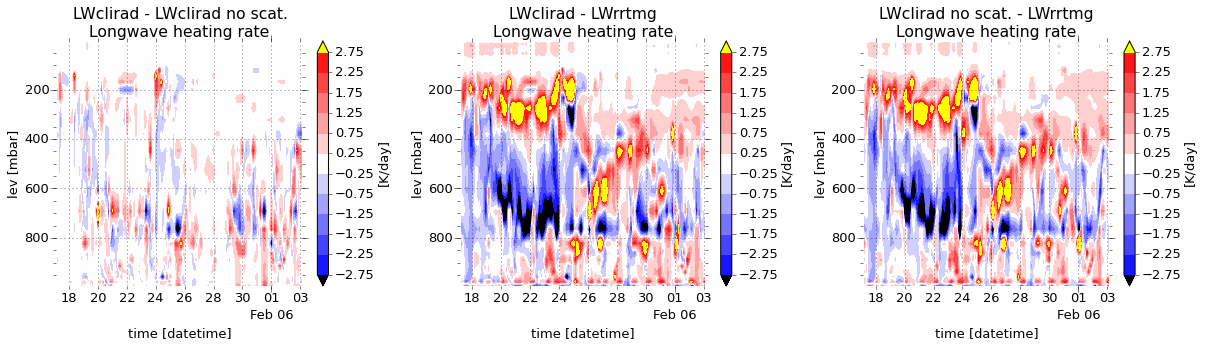

In [81]:
contourf_interest_for_all_cases(diff_d3sets, interest = 'QRL',
                               cmap = plt.get_cmap('bwr'),
                               contour_levels = climaviz.symmetric_about_white_cmap_levels(3, 11),
                               extend = 'both')

### Specific humidity (Q)

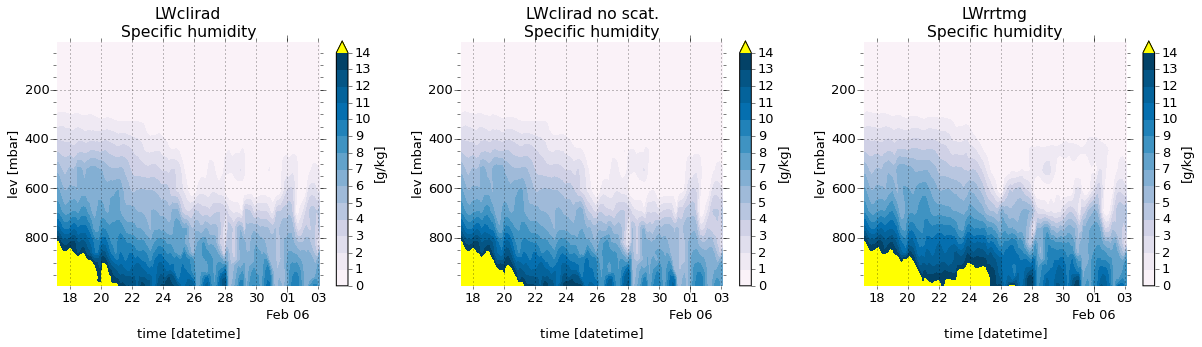

In [82]:
contourf_interest_for_all_cases(d3sets, interest = 'Q',
                               contour_levels = (0, 14, 1),
                                cmap = plt.get_cmap('PuBu'), extend = 'max')

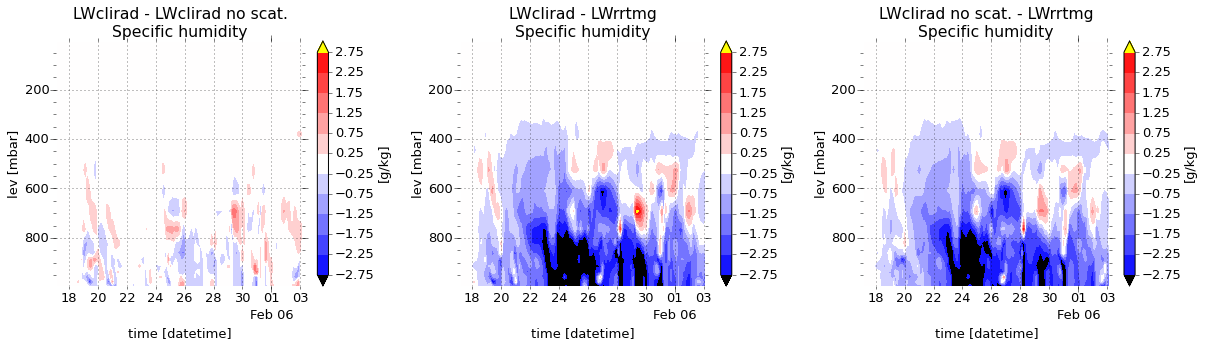

In [83]:
contourf_interest_for_all_cases(diff_d3sets, interest = 'Q',
                               contour_levels = climaviz.symmetric_about_white_cmap_levels(3, 11),
                               extend = 'both', cmap = matplotlib.cm.bwr)

### Grid box averaged cloud ice amount (CLDICE) 

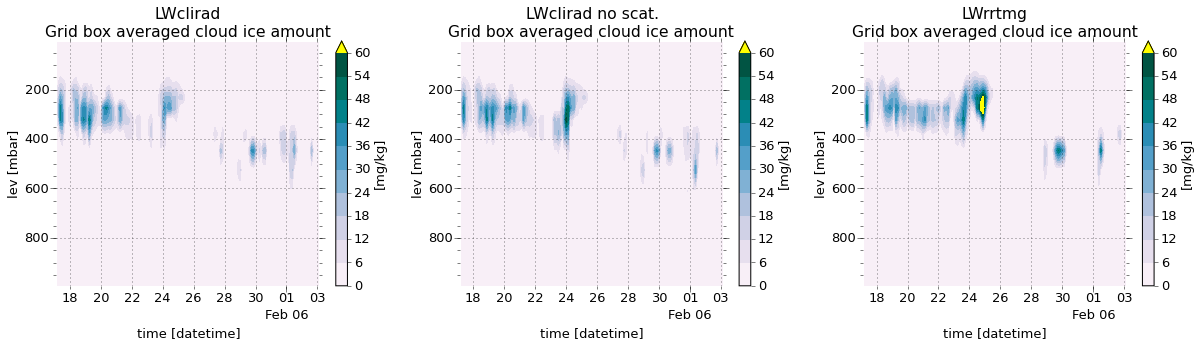

In [102]:
contourf_interest_for_all_cases(d3sets, interest = 'CLDICE',
                                cmap = plt.set_cmap('PuBuGn'), contour_levels = (0, 60, 6),
                               extend = 'max')

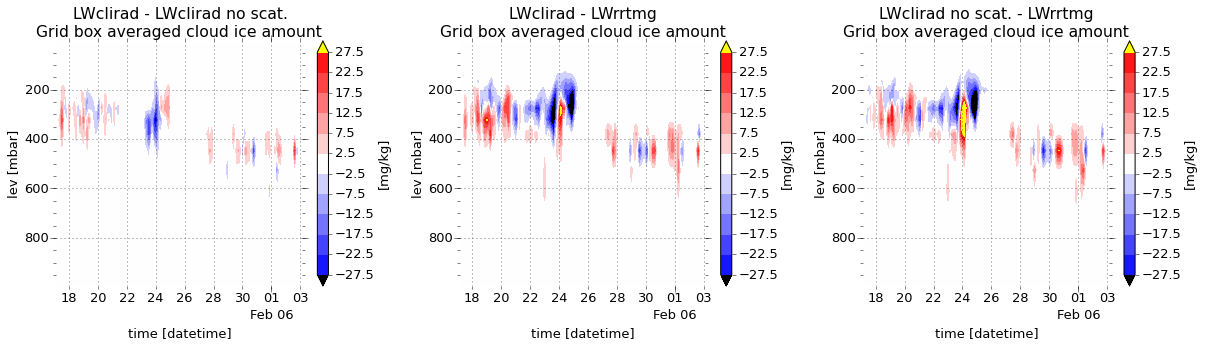

In [103]:
contourf_interest_for_all_cases(diff_d3sets, interest = 'CLDICE', 
                                cmap = plt.set_cmap('bwr'), extend = 'both',
                                contour_levels = climaviz.symmetric_about_white_cmap_levels(30, 11))

### Grid box averaged cloud liquid amount (CLDLIQ)

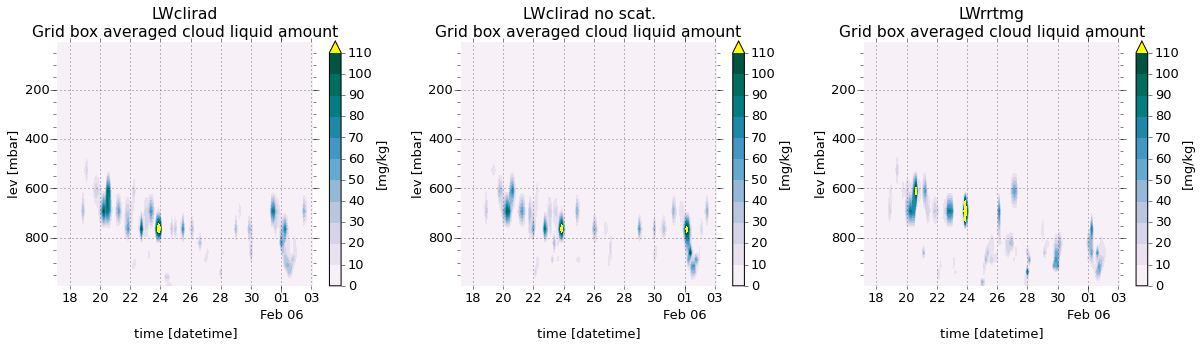

In [108]:
contourf_interest_for_all_cases(d3sets, interest = 'CLDLIQ',
                               cmap = matplotlib.cm.PuBuGn, contour_levels = (0, 110, 10),
                               extend = 'max')

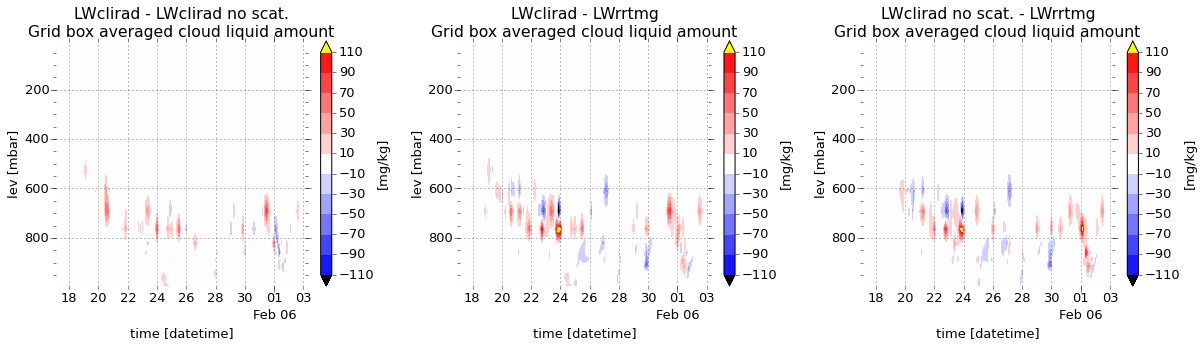

In [120]:
contourf_interest_for_all_cases(diff_d3sets, interest = 'CLDLIQ',
                               cmap = matplotlib.cm.bwr, extend = 'both',
                               contour_levels = climaviz.symmetric_about_white_cmap_levels(100, 11))

### Average snow mixing ratio (AQSNOW)

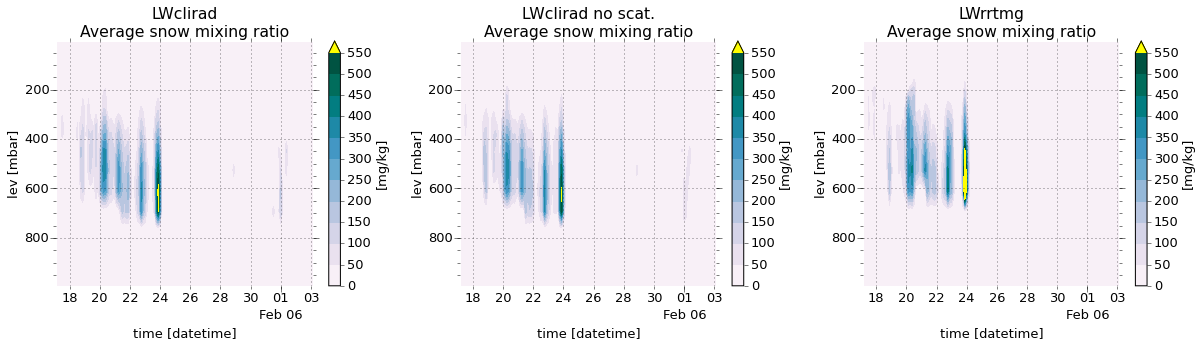

In [130]:
contourf_interest_for_all_cases(d3sets, interest = 'AQSNOW',
                                cmap = plt.get_cmap('PuBuGn'),
                               extend = 'max', contour_levels = (0, 550, 50))

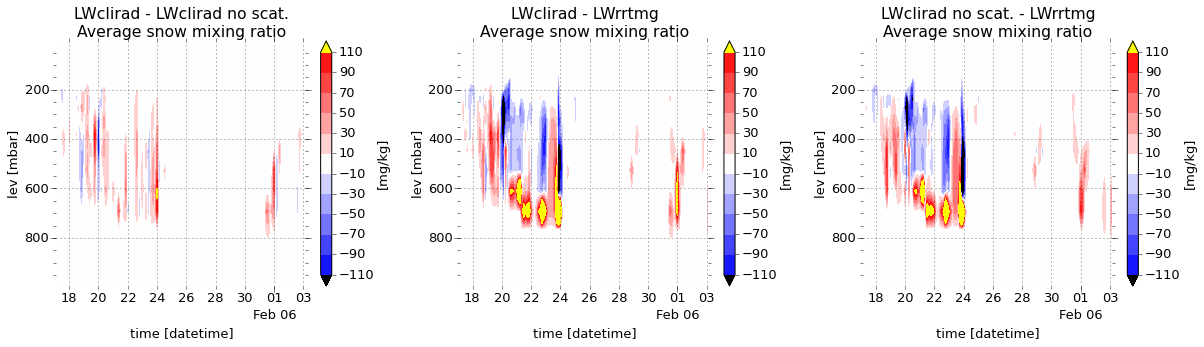

In [134]:
contourf_interest_for_all_cases(diff_d3sets, interest = 'AQSNOW',
                               cmap = plt.get_cmap('bwr'), extend = 'both',
                               contour_levels = climaviz.symmetric_about_white_cmap_levels(110, 11))

### Average ice effective radius (AREI)

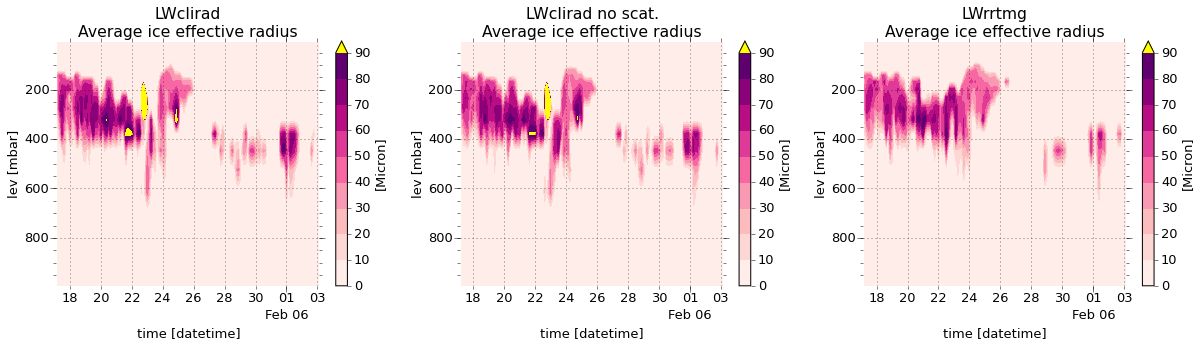

In [138]:
contourf_interest_for_all_cases(d3sets, interest = 'AREI',
                               cmap = plt.get_cmap('RdPu'), extend = 'max',
                               contour_levels = (0, 90, 10))

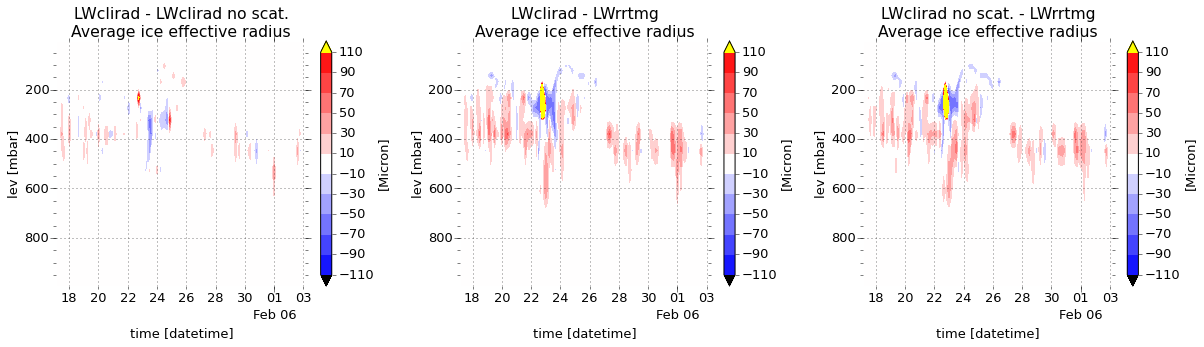

In [141]:
contourf_interest_for_all_cases(diff_d3sets, interest = 'AREI',
                               cmap = plt.get_cmap('bwr'), extend = 'both',
                               contour_levels = climaviz.symmetric_about_white_cmap_levels(100, 11))

### Average droplet effective radius (AREL)

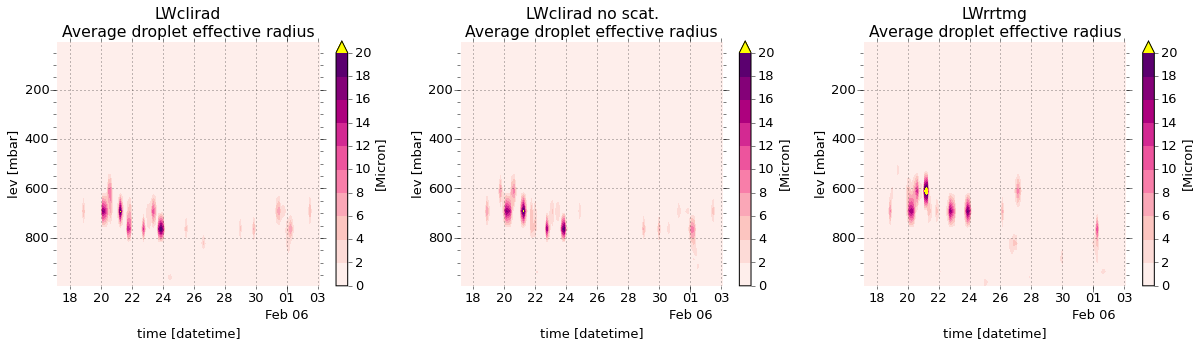

In [144]:
contourf_interest_for_all_cases(d3sets, interest = 'AREL',
                               cmap = plt.get_cmap('RdPu'), extend = 'max',
                               contour_levels = (0, 20, 2))

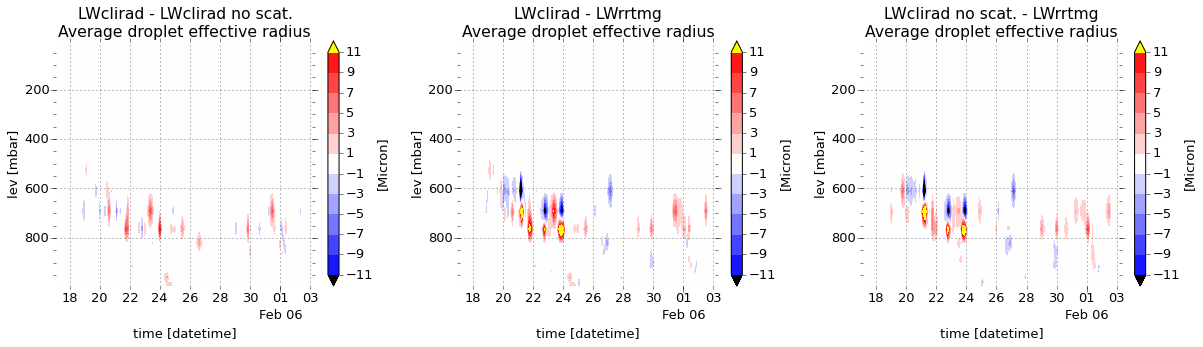

In [148]:
contourf_interest_for_all_cases(diff_d3sets, interest = 'AREL',
                               cmap = plt.get_cmap('bwr'), extend = 'both',
                               contour_levels = climaviz.symmetric_about_white_cmap_levels(9, 11))

### Net longwave flux at top of model (FLNT)

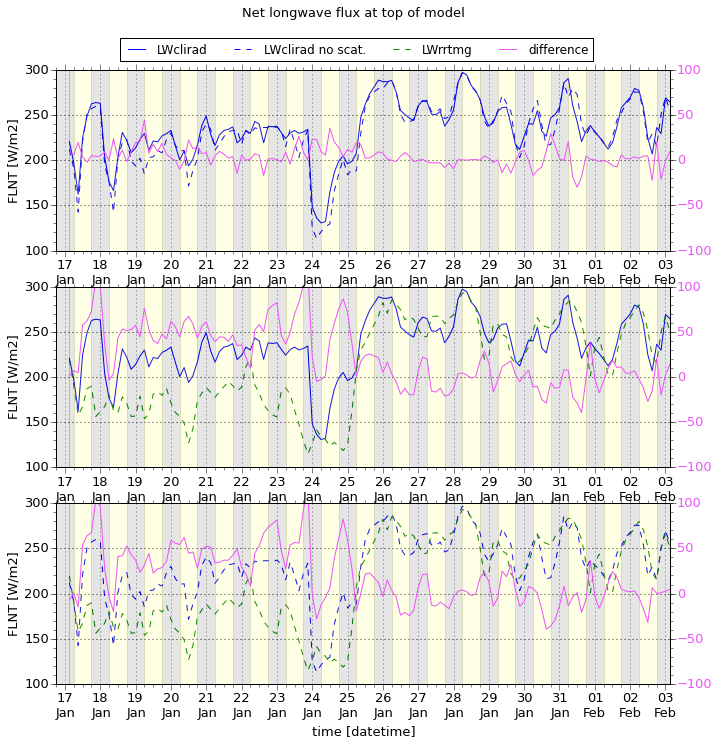

In [84]:
plotVS_interest_for_all_cases(d2sets, diff_d2sets, interest = 'FLNT',
                             left_ylim = (100, 300), right_ylim = (-100, 100))

### Net longwave flux at surface (FLNS)

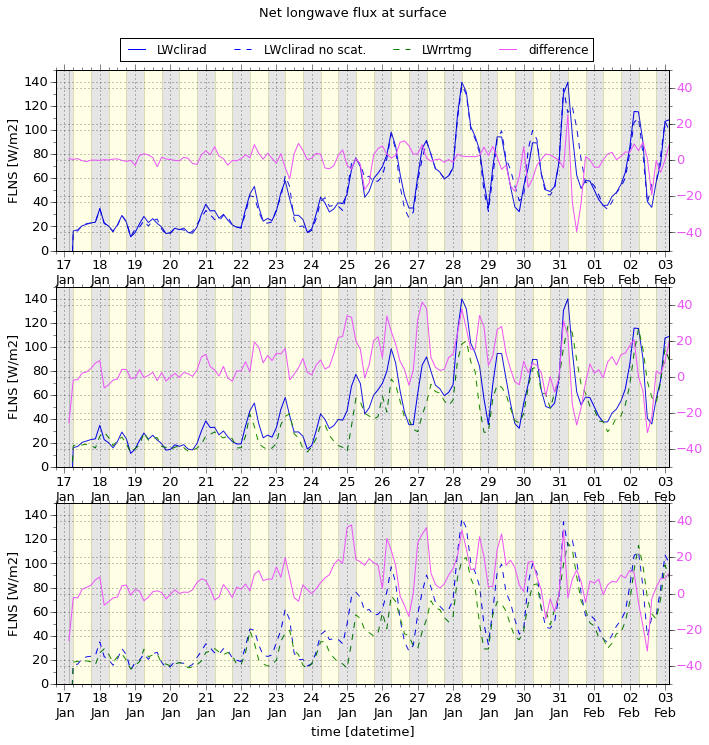

In [85]:
plotVS_interest_for_all_cases(d2sets, diff_d2sets, interest = 'FLNS',
                             left_ylim = (0, 150), right_ylim = (-50, 50))

###  Vertically-integrated low cloud (CLDLOW)

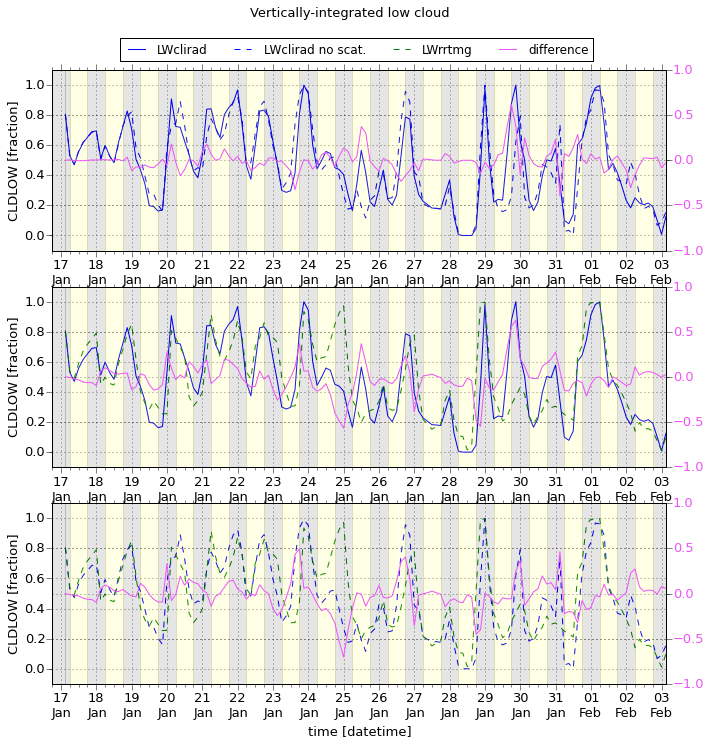

In [149]:
plotVS_interest_for_all_cases(d2sets, diff_d2sets, interest = 'CLDLOW',
                             left_ylim = (-.1, 1.1))

### Vertically-integrated mid-level cloud (CLDMED)

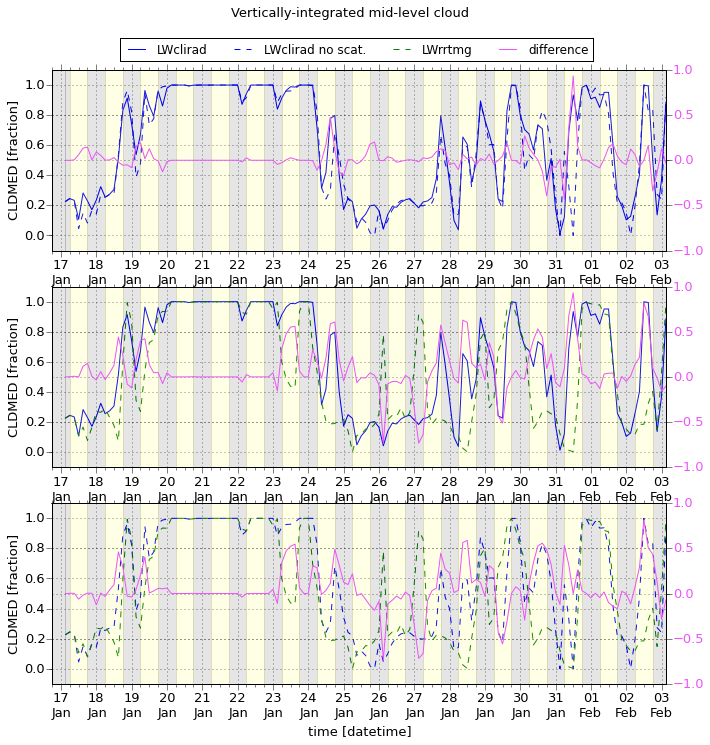

In [150]:
plotVS_interest_for_all_cases(d2sets, diff_d2sets, interest = 'CLDMED',
                             left_ylim = (- .1, 1.1))

###  Vertically-integrated high cloud (CLDHGH)

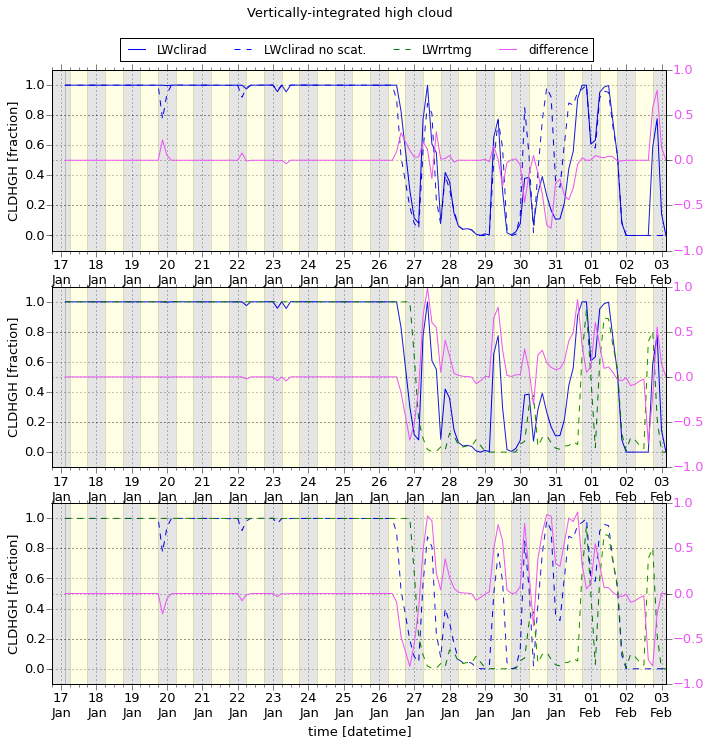

In [151]:
plotVS_interest_for_all_cases(d2sets, diff_d2sets, interest = 'CLDHGH',
                             left_ylim = (- .1, 1.1))

### Vertically-integrated total cloud (CLDTOT)

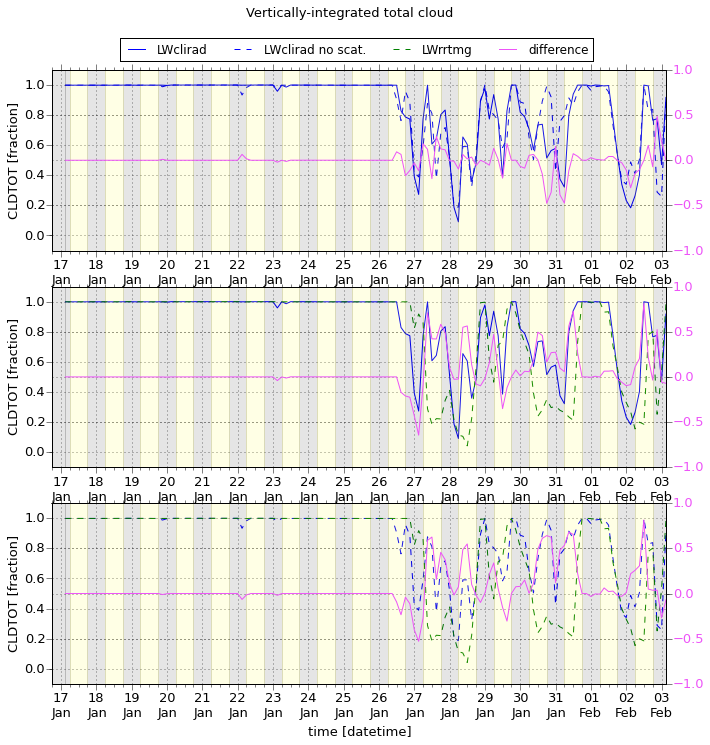

In [152]:
plotVS_interest_for_all_cases(d2sets, diff_d2sets, interest = 'CLDTOT',
                             left_ylim = (- .1, 1.1))